# Conjugate gradient solver

An exploration of the conjugate gradient solver. Considering the problem of getting reflectivity from a seismic trace, given the wavelet.

This was the topic of a previous tutorial which used the numpy and scipy matrix solvers. This notebook solves same problem by the conjugate gradient method and compares the result to the matrix solver results.

We'll be working on a model, so we know the correct answer from the start.

In [1]:
import sys
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt

print ("sys.version=", sys.version)
print ("np.__version__=", np.__version__)

sys.version= 3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]
np.__version__= 1.13.3


## Construct the model `m`

We start with the slightly odd-seeming number of samples 51. This is because when we calculate the impedance contrasts (reflectivities), we'll lose a sample. Since I'd like 50 samples in the final reflectivity model `m`, we have to start with 50 + 1 samples in the impedance model.


In [2]:
# Impedance, imp     VP    RHO
imp = np.ones(51) * 2550 * 2650
imp[10:15] =        2700 * 2750
imp[15:27] =        2400 * 2450
imp[27:35] =        2800 * 3000

# Compute reflectivity.
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

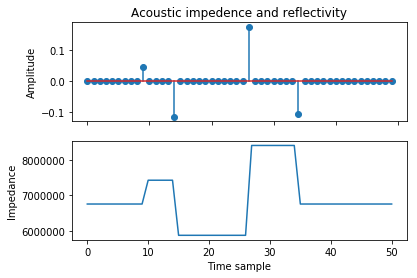

In [3]:
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.set_title('Acoustic impedence and reflectivity')
ax.set_ylabel('Amplitude')
ax.set_xticklabels([])
ax.stem(m)

ax = axs[1]
ax.plot(imp)
ax.set_xlabel('Time sample')
ax.set_ylabel('Impedance')

plt.show()

Notice that we lost a sample: now there are only 50 samples. This is what we wanted.

In [4]:
m.size

50

## Forward operator: convolution with wavelet

Now we make a Ricker wavelet to convolve on the reflectivity.


In [5]:
from scipy.signal import ricker

# Use an odd number so we get a centered peak.
wavelet = ricker(points=21, a=2)

# Normalize the wavelet amplitude to 1 so that the amplitude
# relates directly to the reflectivity.
wavelet /= np.amax(wavelet)

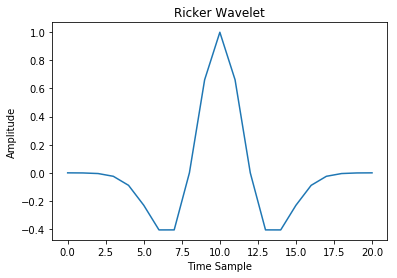

In [6]:
# Make a plot.
fig, ax = plt.subplots()

ax.set_title('Ricker Wavelet')
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(wavelet)

plt.show()

## Forward model the data d

Now computing the data by convolving the Ricker wavelet on the reflectivity.

In [7]:
d = np.convolve(wavelet, m, mode='same')

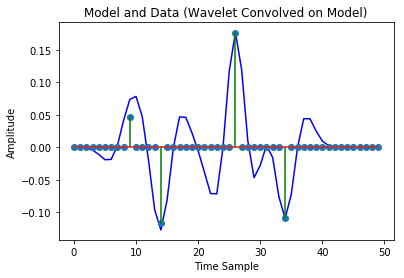

In [8]:
# Plot model and the data, d.
fig, ax = plt.subplots()

ax.set_title('Model and Data (Wavelet Convolved on Model)')
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(d,'b')
ax.stem(m,'g')

#plt.savefig('figure_model_data.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

## Define the convolution function with adjoint

Define the Claerbout-style convolution function that has switches for `add` and `adj`:

In [88]:
def adj_null(adj, add, x, y):
    """
    Initialize x and y
    """
    if add:
        return x, y
    if adj:
        x[:] = 0
    else:
        y[:] = 0
    return x, y

def convolve(adj, add, x, y, wavelet, lag_t0):
    """
    Implement the linear convolutional operator and
    its adjoint, a la Claerbout.
    """
    x, y = adj_null(adj, add, x, y)

    for iwavelet in range(wavelet.size):
        shift = iwavelet - lag_t0
        print(shift)
        if adj:
            if shift == 0:
                x += y * wavelet[iwavelet]
            elif shift > 0:
                x[:-shift] += y[shift:] * wavelet[iwavelet]
            else:
                x[-shift:] += y[:shift] * wavelet[iwavelet]
        else:
            if shift == 0:
                y += x * wavelet[iwavelet]
            elif shift > 0:
                y[shift:] += x[:-shift] * wavelet[iwavelet]
            else:
                y[:shift] += x[-shift:] * wavelet[iwavelet]
    if adj:
        return x
    else:
        return y

In [77]:
def convolve(adj, add, x, y, wavelet, lag_t0):
    """
    Implement the linear convolutional operator and
    its adjoint, a la Claerbout.
    """
    if adj:
        return np.correlate(y, wavelet, mode='same')
    else:
        return np.convolve(x, wavelet, mode='same')

Convolve the Ricker wavelet using `np.convolve()`, and the new `convolve` function. Overplot them to check results are same.

In [78]:
wavelet_lag_t0 = int(wavelet.size/2)
d_new = np.zeros(m.size)
d_new = convolve(False, False, m, d_new, wavelet, wavelet_lag_t0)

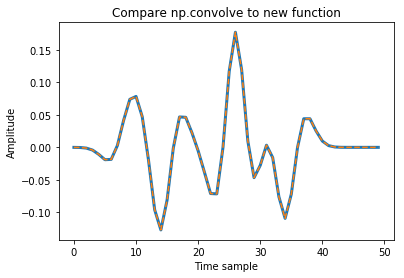

In [79]:
fig, ax = plt.subplots()

ax.plot(d_new, lw=3)
ax.plot(d, '--')
ax.set_title('Compare np.convolve to new function')
ax.set_xlabel('Time sample')
ax.set_ylabel('Amplitude')

plt.show()

Test the adjoint switch. The adjoint should reverse the wavelet. Make an asymetrical wavelet for testing.

In [80]:
w_asym = np.array([0.0, 0.0, 1.0, -2.0, 0.2, 0.0, 0.0])
w_asym_lag_t0 = 3

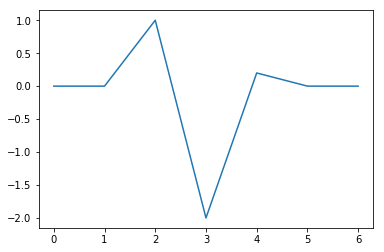

In [81]:
plt.plot(w_asym)

Make a test trace that is 51 points, all 0 except the center point, which is 1.

In [82]:
m_ = np.zeros(50)
m_[int(m_.size / 2)] = 1.0
d_asym_new = np.zeros(m_.size)

d_asym = np.convolve(w_asym, m_, mode='same')
d_asym_new = convolve(True, False, d_asym_new, m_, w_asym, w_asym_lag_t0)

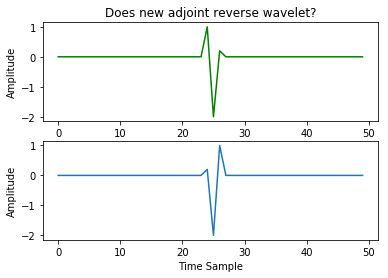

In [83]:
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.set_title('Does new adjoint reverse wavelet?')
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(d_asym,'g')

ax = axs[1]
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(d_asym_new)

plt.show()

Test that the adj is working correctly. Previous visual tests looks good. The asymetric wavelet is flipped.
Claerbout recommends "the dot product test". The adjoint of the operator A is defined as the operator A1 such that 

    <A x, y> = <x, A1 y>

for any vectors x and y. "The dot product test" is to use random x and y vectors, check that:

    <convolve(x), y> = <x, convolveadj(y)>

This is not a perfect test, but it will catch most problems.

In [89]:
x = np.random.rand(50)
y = np.random.rand(50)

convolvex = np.random.rand(50)
convolveadjy = np.random.rand(50)
y = convolve(False, False, x           , convolvex, w_asym, 0)
x = convolve(True , False, convolveadjy, y        , w_asym, 0)

print('   <convolve(x), y> =', np.dot(convolvex, y))
print('<x, convolveadj(y)> =', np.dot(x, convolveadjy))
print('         difference =', np.dot(convolvex, y) - np.dot(x, convolveadjy))

0
1
2
3
4
5
6
0
1
2
3
4
5
6
   <convolve(x), y> = 29.3918363658
<x, convolveadj(y)> = 152.341976035
         difference = -122.950139669


## Estimate model using conjugate gradient method

First simpify Guo's pseudocode removing right proconditioner, ie set R = identity. This makes `z` the same as `deltax`. The resulting pseudocode is:

    x = 0
    r = d - F * x
    s = 0
    beta = 0
    iterate (
       deltax = F' * r
       if not first iteration beta = <deltax, deltax> / gamma
       gamma = <deltax, deltax>
       s = deltax + beta * s
       deltar = F*s
       alpha = gamma / <deltar, deltar>
       x = x + alpha * s
       r = r - alpha * deltar
    )

Adapt the pseudo code variables to solve our problem:

- `x`: `m_est`, the model we are trying to estimate
- `d`: `d`, the seimsic trace
- `F`: `G`, the convolution operator

#### Which notation does the code use though? Seems to stick to Guo's notation? I think, on balance, it's best to stick to one notation throughout. I think staying with Gm = d might be the least confusing.

In [34]:
x = np.zeros(d.size)
F_x = np.zeros(d.size)  # It seems like this should be G(x), which is the same thing but more correct
r = d - F_x
s = np.zeros(d.size)
beta = 0.0
niter = 5

deltax = np.zeros(d.size)  # Confused about which notation we're using.
deltar = np.zeros(d.size)

cache = []
for iter in range(niter):
    deltax = convolve(True, False, deltax, r, wavelet, wavelet_lag_t0)
    if iter != 0:
        beta = np.dot(deltax, deltax)
    gamma = np.dot(deltax, deltax)
    s = deltax + beta * s
    deltar = convolve(False, False, s, deltar, wavelet, wavelet_lag_t0)
    alpha = gamma / np.dot(deltar, deltar)
    x = x + alpha * s
    r = r - alpha * deltar
    cache.append(x)

m_est = x  # Seems unnecessary to do this... just start with m_est or x and stick with it

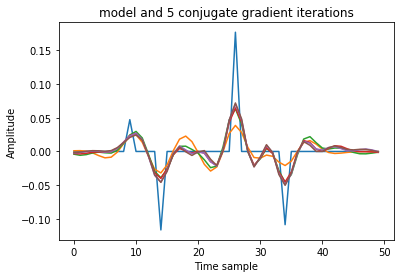

In [35]:
fig, ax = plt.subplots()

ax.set_title(f'model and {niter} conjugate gradient iterations')
ax.set_xlabel('Time sample')
ax.set_ylabel('Amplitude')

plt.plot(m)
for x in cache:
    plt.plot(x)

# plt.savefig('figure_cg_est_iter.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

Compare `G @ m_est` (called `d_pred` below) to the original data, `d`:

In [64]:
d_pred = np.zeros(m_est.size)
d_pred = convolve(False, False, m_est, d_pred, wavelet, wavelet_lag_t0)

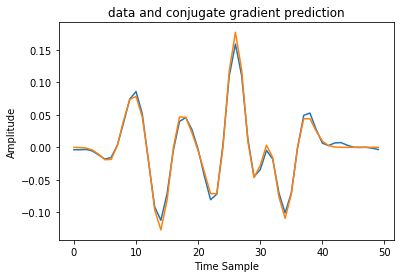

In [65]:
fig, ax = plt.subplots()

ax.set_title('data and conjugate gradient prediction')
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')
ax.plot(d_pred)
ax.plot(d)

# plt.savefig('figure_data_cg_pred.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

We only did 5 iteratations; more iterations would make these match exactly.

## Estimate the model using the preconditioned conjugate gradient method

I will use the previous unconditioned results and attempt to concentrate amplitude in the locations that already have large amplitude. The  preconditioner is to scale by sqrt(previous result smoothed amplitude^2). This scalar is just the RMS of a 3 point sliding window. The effect will be to make large amplitudes larger and small amplitudes smaller in the estimated model.

Compute R the right preconditioning diagonal matrix.

### NB R is not a matrix, but a 1D array.

In [66]:
boxcar = np.ones(3) / 3.0
R = np.sqrt(np.convolve(boxcar, m_est*m_est, mode='same'))

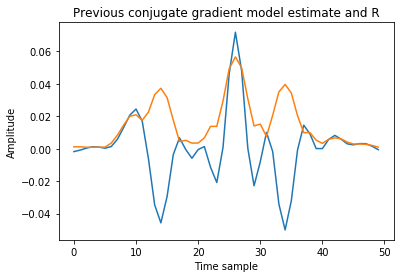

In [67]:
fig, ax = plt.subplots()

ax.set_title('Previous conjugate gradient model estimate and R')
ax.set_xlabel('Time sample')
ax.set_ylabel('Amplitude')
ax.plot(m_est)
ax.plot(R)

# plt.savefig('figure_cg_est_R.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

Guo's original pseudo code to solve:

    F R x' = d
    x = R x'
    r = d - F x
    s = 0
    beta = 0
    iterate (
       deltax = F' r
       z = R R' deltax
       if not first iteration:
           beta = <deltax, z> / gamma
       gamma = <deltax, z>
       s = z + beta s
       deltar = F s
       alpha = gamma / <deltar,deltar>
       x = x + alpha s
       r = r - alpha deltar
    )

Adapt the pseudo code variables to solve our problem

- `x`: `m_est` the model we are trying to estimate
- `d`: `d` the seimsic trace
- `F`: the convolution operator

In [68]:
x = np.zeros(d.size)
F_x = np.zeros(d.size)
x = convolve(False, False, x, F_x, wavelet, wavelet_lag_t0)
r = d - F_x
beta = 0.0
niter = 5
deltax = np.zeros(d.size)
deltar = np.zeros(d.size)
s = np.zeros(d.size)

cache = []
for iter in range(niter):
    deltax = convolve(True, False, deltax, r, wavelet, wavelet_lag_t0)
    z = R * R * deltax
    if iter != 0:
        beta = np.dot(deltax, z)
    gamma = np.dot(deltax, z)
    s = z + beta * s
    deltar = convolve(False, False, s, deltar, wavelet, wavelet_lag_t0)
    alpha = gamma / np.dot(deltar, deltar)
    x = x + alpha * s
    r = r - alpha * deltar
    cache.append(x)

m_pcest = x  # Again, let's stick with one notation.

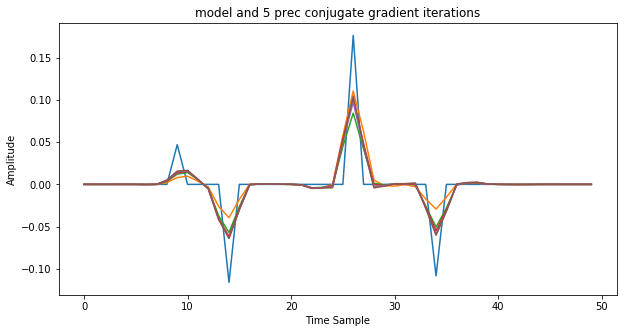

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(m)
for x in cache:
    ax.plot(x)

ax.set_title('model and %d prec conjugate gradient iterations'%niter)
ax.set_xlabel('Time Sample')
ax.set_ylabel('Amplitude')

# plt.savefig('figure_model_pcg_est_iter.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

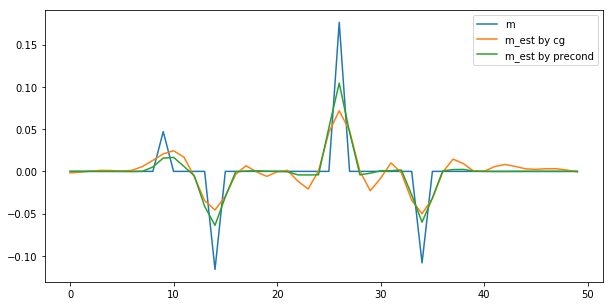

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(m, label='m')
ax.plot(m_est, label='m_est by cg')
ax.plot(m_pcest, label='m_est by precond')
ax.legend()

# ax.savefig('figure_model_cg_pcg_est.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

## Compare to `scipy.sparse.linalg.cg`

https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.linalg.cg.html

In [34]:
import scipy.sparse.linalg as sla

In [35]:
sla.LinearOperator?

In [36]:
def mv(v):
    """
    The forward operator, convolution.
    """
    return np.convolve(v, wavelet, mode='same')

def hv(v):
    """
    Defines the complex conjugate transpose or adjoint operator.
    For convolution this is crosscorrelation.
    """
    return np.correlate(v, wavelet, mode='same')

G = sla.LinearOperator((d.size, m.size), matvec=mv, rmatvec=hv)

Check that this works as expected:

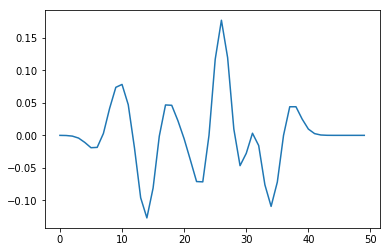

In [37]:
d_ = G @ m

plt.plot(d_)

### Solving with adjoint as before

First, we'll solve manually, without using the built-in solver.

In [38]:
sla.LinearOperator?

In [41]:
import numpy.linalg as la

# Initial guess and initial residual.
x = np.zeros_like(d)
d_pred = G @ x
r = d - d_pred
s = np.zeros_like(d)

niter = 5

cache = []
for i in range(niter):
    deltax = G.adjoint() @ r
    gamma = la.norm(deltax)**2
    beta = bool(i) * gamma
    s = deltax + beta * s
    deltar = G @ s
    alpha = gamma / la.norm(deltar)**2
    x += alpha * s
    r -= alpha * deltar
    cache.append(x)

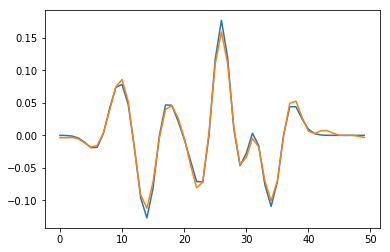

In [42]:
d_ = G @ x

plt.plot(d)
plt.plot(d_)

### Using SciPy's `cg` to solve

In [43]:
sla.cg?

In [44]:
m_cg, _ = sla.cg(G, d, maxiter=5)

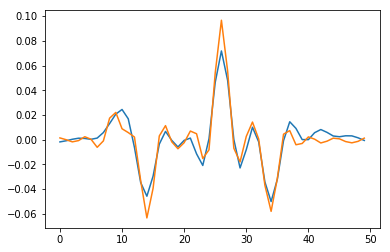

In [45]:
plt.plot(m_est)
plt.plot(m_cg)

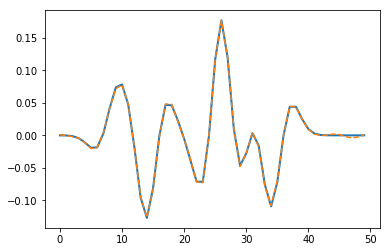

In [46]:
d_ = G @ m_cg

plt.plot(d, lw=2)
plt.plot(d_, '--')

### Add preconditioning matrix

In [49]:
def rv(v):
    """
    Right precond matrix. Cannot depend on v.
    Use RMS of previous result.
    """
    return np.sqrt(np.convolve(boxcar, m_cg**2, mode='same'))

R = sla.LinearOperator((d.size, m.size), matvec=rv)

In [50]:
m_pcg, _ = sla.cg(G, d, M=R, maxiter=5)

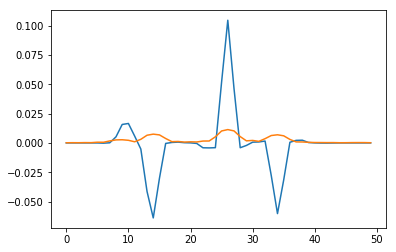

In [51]:
plt.plot(m_pcest)
plt.plot(m_pcg)

Hm, okay, I guess I don't quite get how to set up the preconditioning matrix.

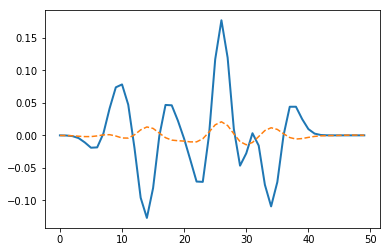

In [52]:
d_ = G @ m_pcg

plt.plot(d, lw=2)
plt.plot(d_, '--')

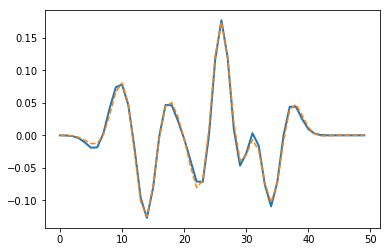

In [53]:
d_ = G @ m_pcest

plt.plot(d, lw=2)
plt.plot(d_, '--')